# Experimenting with the effect of maxPooling

In [1]:
%matplotlib inline

import torch
from torch import Tensor
import dlc_practical_prologue as prologue
from matplotlib import pyplot as plt
import time

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

In [176]:
# Load MNIST dataset (reduced set)
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = True, normalize = True, flatten = False)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [177]:
# Visualize dataset dimensions
print('train_input:',train_input.shape)
print('test_input:',test_input.shape)
print('train_target:',train_target.shape)
print('test_target:',test_target.shape)

train_input: torch.Size([1000, 1, 28, 28])
test_input: torch.Size([1000, 1, 28, 28])
train_target: torch.Size([1000, 10])
test_target: torch.Size([1000, 10])


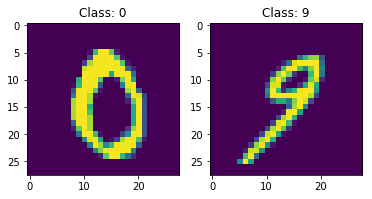

image size: torch.Size([28, 28])


In [190]:
# Dataset visualization
sample = 582
fig,axis = plt.subplots(1,2)
axis[0].imshow(train_input[sample,0])
axis[0].set_title('Class: {}'.format(torch.argmax(train_target[sample])))
axis[1].imshow(train_input[sample+1,0])
axis[1].set_title('Class: {}'.format(torch.argmax(train_target[sample+1])))
plt.show()
print('image size:',train_input[sample,0].shape)

In [192]:
# Professor example
class ProfessorNet(nn.Module):
    def __init__(self):
        super(ProfessorNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [193]:
# Derived from professor's example, without maxPooling
class SimplifiedNet(nn.Module):
    def __init__(self):
        super(SimplifiedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*20*20, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(-1, 64*20*20)))
        x = self.fc2(x)
        return x

In [194]:
# Function to train a model
def train_model(model, train_input, train_target, mini_batch_size):
    criterion = nn.MSELoss()
    eta = 1e-1
    for e in range(0, 25):
        sum_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        print(e, sum_loss)

In [195]:
# Evaluate the network's performance with winner takes it all approach
def compute_nb_errors(model, input_, target, mini_batch_size):
    error = 0
    for b in range(0, input_.size(0), mini_batch_size):
        output = model(input_.narrow(0, b, mini_batch_size))
        
        c_array = output.argmax(1)
        t_array = target[b:b+mini_batch_size].argmax(1)
        error += (c_array-t_array).nonzero().size()[0]
        
    return error/input_.size()[0]*100

In [17]:
# Train the professor's model and evaluate it
model = ProfessorNet() 
mini_batch_size = 100

train_model(model, train_input, train_target, mini_batch_size)
print('Loss on test set:', compute_nb_errors(model, test_input, test_target, mini_batch_size),'%')

0 0.8870525732636452
1 0.7685782760381699
2 0.6961821764707565
3 0.6333322450518608
4 0.5808088779449463
5 0.5388898029923439
6 0.5061322301626205
7 0.4807812049984932
8 0.45905613899230957
9 0.4392935335636139
10 0.42149854078888893
11 0.404970396310091
12 0.3899703547358513
13 0.39278144761919975
14 0.3700929917395115
15 0.3485518004745245
16 0.3407313097268343
17 0.3286995254456997
18 0.31756569631397724
19 0.3365845810621977
20 0.3131201360374689
21 0.2894383352249861
22 0.2835408467799425
23 0.2781979199498892
24 0.2740096766501665
Loss on test set: 15.7 %


In [23]:
# Train the simplified model and evaluate it
model = SimplifiedNet() 
mini_batch_size = 100

train_model(model, train_input, train_target, mini_batch_size)
print('Loss on test set:', compute_nb_errors(model, test_input, test_target, mini_batch_size),'%')

0 0.8254552185535431
1 0.6248150393366814
2 0.5219256095588207
3 0.41258498281240463
4 0.3728884756565094
5 0.34388227574527264
6 0.3034926690161228
7 0.2802353519946337
8 0.25411636382341385
9 0.24268661998212337
10 0.23081058077514172
11 0.20639300346374512
12 0.19570204615592957
13 0.17976822145283222
14 0.179344835691154
15 0.16625335346907377
16 0.1509782550856471
17 0.1493746917694807
18 0.1418860461562872
19 0.1328622940927744
20 0.12497582007199526
21 0.12860154546797276
22 0.12318934593349695
23 0.11285346280783415
24 0.10832641366869211
Loss on test set: 8.799999999999999 %


# Project 1
Load the dataset:

In [2]:
# Load the dataset
nb = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb)

In [3]:
# Display the data shape
print('train_input:',train_input.shape)
print('train_target:',train_target.shape)
print('train_classes:',train_classes.shape)
print('test_input:',test_input.shape)
print('test_target:',test_target.shape)
print('test_classes:',test_classes.shape)

train_input: torch.Size([1000, 2, 14, 14])
train_target: torch.Size([1000])
train_classes: torch.Size([1000, 2])
test_input: torch.Size([1000, 2, 14, 14])
test_target: torch.Size([1000])
test_classes: torch.Size([1000, 2])


## Visualise the dataset

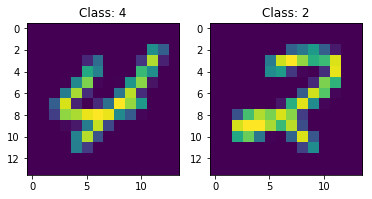

Expected classification:  0


In [4]:
# Dataset visualization
sample = 593
fig,axis = plt.subplots(1,2)
axis[0].imshow(train_input[sample,0])
axis[0].set_title('Class: {}'.format(train_classes[sample,0]))
axis[1].imshow(train_input[sample,1])
axis[1].set_title('Class: {}'.format(train_classes[sample,1]))
plt.show()
print('Expected classification: ',train_target[sample].item())

## Network Architecture
Define a module responsible for recognizing the classes and another that will identify if the first digit is less or equal to the second.

### Class identifier

In [5]:
# Define a Net that works with a single image (hence channel dim = 1)
class Parallel_Net(nn.Module):
    '''
        Building block used to classify the digit.

        Net input: Nx1x14x14 (single image)
        Net output: 10x1
    '''
    def __init__(self):
        super(Parallel_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*3*3, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.fc1(x.view(-1, 64*3*3)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

### Relation identifier

In [18]:
class Analyzer_Net(nn.Module):
    '''
        Building block used to infer digit's relation.

        Net input: 20x1 (digit classification)
        Net output: 1x1 (bigger or smaller)
    '''
    def __init__(self):
        super(Analyzer_Net, self).__init__()
        self.fc1 = nn.Linear(2*10, 15)
        self.fc2 = nn.Linear(15, 10)
        self.fc3 = nn.Linear(10, 5)
        self.fc4 = nn.Linear(5, 2) 
        
    def forward(self,x):
        '''x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)''' # torch.sigmoid() maybe?
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

## Build a Basic Network with only a MSE loss on the target

In [7]:
class BasicNet(nn.Module):
    '''
        Net caracteristics:
            - No weight sharing
            - No intermediate loss
        
        Net input: Nx2x14x14
        Net output: 2x1 
    '''
    def __init__(self):
        super(BasicNet, self).__init__()
        self.parallel_net1 = Parallel_Net()
        self.parallel_net2 = Parallel_Net()
        self.analyser_net  = Analyzer_Net()
    
    def forward(self,x):
        # Split the 2 input channels
        x1 = x[:,0,:,:].view(-1,1,14,14)
        x2 = x[:,1,:,:].view(-1,1,14,14)

        # No weight sharing (declare 2 distinct instances of Parallel_Net)
        x1 = self.parallel_net1(x1)
        x2 = self.parallel_net2(x2)

        # Concatenate back both classification results 
        x = torch.cat((x1.view(-1,10),x2.view(-1,10)),dim=1)
        x = self.analyser_net(x)

        return x 

### Train the network

In [26]:
def trainMSE(model, train_input, train_target, mini_batch_size):
    train_target = train_target.type(torch.FloatTensor)

    # Specify the loss function
    criterion = nn.MSELoss()

    # Define the number of epochs to train the network
    epochs = 25
    
    # Set the learning rate
    eta = 0.01

    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size)) # dim,start,length
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            sum_loss = sum_loss + loss.item()
            model.zero_grad()
            loss.backward()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        #return
        print('Sum of loss at epoch {}: \t'.format(e),sum_loss)
    
    return model

In [9]:
def evaluateFinalOutput(model,test_input, test_target,mini_batch_size):
    test_target = test_target.type(torch.FloatTensor)
    
    with torch.no_grad():
        error = 0
        for b in range(0, test_input.size(0), mini_batch_size):
            output = model(test_input.narrow(0, b, mini_batch_size))
            for i in range(output.size(0)):
                #print(output[i].item(),test_target.narrow(0, b, batch_size)[i].item())
                if output[i].item() >= 0.5:
                    if test_target.narrow(0, b, mini_batch_size)[i].item() < 0.2:
                        error += 1
                elif output[i].item() < 0.5:
                    if test_target.narrow(0, b, mini_batch_size)[i].item() > 0.8:
                        error += 1
                else:
                    error += 1
    return error/test_target.size(0)*100

In [27]:
# Define the mini_batch size
mini_batch_size = 200

# Create an instance of the network
basicModel = BasicNet()
num_param = sum(p.numel() for p in basicModel.parameters() if p.requires_grad)
print('Number of trainable parameters:',num_param)

Number of trainable parameters: 99352


In [28]:
# Train the network
basicModel = trainMSE(basicModel,train_input, train_target, mini_batch_size)

Sum of loss at epoch 0: 	 1.4364519715309143
Sum of loss at epoch 1: 	 1.2671064138412476
Sum of loss at epoch 2: 	 1.2653934359550476
Sum of loss at epoch 3: 	 1.2639169991016388
Sum of loss at epoch 4: 	 1.2626781463623047
Sum of loss at epoch 5: 	 1.2615963518619537
Sum of loss at epoch 6: 	 1.2606699168682098
Sum of loss at epoch 7: 	 1.2598430216312408
Sum of loss at epoch 8: 	 1.259132742881775
Sum of loss at epoch 9: 	 1.25843845307827
Sum of loss at epoch 10: 	 1.257744938135147
Sum of loss at epoch 11: 	 1.2571662068367004
Sum of loss at epoch 12: 	 1.2567053139209747
Sum of loss at epoch 13: 	 1.256271868944168
Sum of loss at epoch 14: 	 1.2558508962392807
Sum of loss at epoch 15: 	 1.2554482817649841
Sum of loss at epoch 16: 	 1.2550633698701859
Sum of loss at epoch 17: 	 1.254713088274002
Sum of loss at epoch 18: 	 1.2543928176164627
Sum of loss at epoch 19: 	 1.2540881782770157
Sum of loss at epoch 20: 	 1.2537960559129715
Sum of loss at epoch 21: 	 1.2535055577754974
Sum 

In [29]:
# Evaluate the performance of the model
res = evaluateFinalOutput(basicModel,test_input,test_target,mini_batch_size)
print('Error rate of the model: ',res,'%')

Error rate of the model:  50.1 %


## Add cross-entropy loss at the classification level

### Note: Distinction between `clone()` and `copy_()`
Both functions allow to create a clone of a Tensor instance. The difference is that using `clone()`, this function is recorded in the computation graph. Gradients propagating to the cloned tensor will propagate to the original tensor!
Therefore `copy_()` allows to fully separate the cloned tensor from its original version and makes it independent.

Check [the doc](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.clone) for more details (`copy_` is right below `clone`).

In [212]:
# TODO

## Train each submodule individually

### Train the Class Identifier

In [7]:
def trainClassIdentifier(model, train_input, train_classes, mini_batch_size):
    
    # Specify the loss function
    criterion = nn.CrossEntropyLoss()

    # Define the number of epochs to train the network
    epochs = 25
    
    # Set the learning rate
    eta = 0.01

    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            model.zero_grad()
            for i in range(2):
                # For each image (since there are 2 channels)
                output = model(train_input[:,i].view(-1,1,14,14).narrow(0, b, mini_batch_size)) # dim,start,length
                loss = criterion(output, train_classes[:,i].narrow(0, b, mini_batch_size))
                sum_loss += loss.item()
                loss.backward()
            for p in model.parameters():
                p.data.sub_(eta * p.grad.data)
        #return
        print('Sum of loss at epoch {}: \t'.format(e),sum_loss)
    
    return model

In [8]:
# Evaluate the network's performance with winner takes it all approach
def evaluateClassIdentification(model, test_input, test_classes, mini_batch_size):
    error = 0
    for b in range(0, test_input.size(0), mini_batch_size):
        output = model(test_input[:,0].view(-1,1,14,14).narrow(0, b, mini_batch_size))
        
        c_array = output.argmax(1)
        t_array = test_classes[:,0][b:b+mini_batch_size]
        error += (c_array-t_array).nonzero().size()[0]
        
    return error/test_input.size()[0]*100

In [9]:
# Define the mini_batch size
mini_batch_size = 200

# Instantiate the model
classModel = Parallel_Net()

In [10]:
classModel = trainClassIdentifier(classModel, train_input, train_classes, mini_batch_size)

Sum of loss at epoch 0: 	 60.63195204734802
Sum of loss at epoch 1: 	 22.20393466949463
Sum of loss at epoch 2: 	 20.315518379211426
Sum of loss at epoch 3: 	 19.85521388053894
Sum of loss at epoch 4: 	 18.008901953697205
Sum of loss at epoch 5: 	 12.561357140541077
Sum of loss at epoch 6: 	 13.687849044799805
Sum of loss at epoch 7: 	 10.33372688293457
Sum of loss at epoch 8: 	 7.455751061439514
Sum of loss at epoch 9: 	 6.146078497171402
Sum of loss at epoch 10: 	 6.269042432308197
Sum of loss at epoch 11: 	 4.6116723120212555
Sum of loss at epoch 12: 	 5.821642756462097
Sum of loss at epoch 13: 	 3.4021140038967133
Sum of loss at epoch 14: 	 2.979199454188347
Sum of loss at epoch 15: 	 4.020108565688133
Sum of loss at epoch 16: 	 2.457531914114952
Sum of loss at epoch 17: 	 3.018318757414818
Sum of loss at epoch 18: 	 3.0352158695459366
Sum of loss at epoch 19: 	 1.943548545241356
Sum of loss at epoch 20: 	 1.7361843436956406
Sum of loss at epoch 21: 	 1.597754642367363
Sum of loss 

In [40]:
# Evaluate the class identification of the model
res = evaluateClassIdentification(classModel, test_input, test_classes, mini_batch_size)
print('Error rate of the model: ',res,'%')

Error rate of the model:  7.199999999999999 %


### Train the Analyzer

In [25]:
def trainAnalyzer(model, train_classes, train_target, mini_batch_size):
    #train_target = train_target.type(torch.FloatTensor)
    # Classify into one-hot
    train_target_oneHot = torch.eye(2)[train_target]
    
    # Specify the loss function
    criterion = nn.MSELoss(reduction='mean')

    # Define the number of epochs to train the network
    epochs = 25
    
    # Set the learning rate
    eta = 1e-0
    optimizer = torch.optim.SGD(model.parameters(), lr = eta)
    
    # One hot encode the training classes and concatenate them (1000x2)->(1000x2x10)
    train_oneHot = torch.empty([train_classes.shape[0],2,10])
    train_oneHot[:,0] = torch.eye(10)[train_classes[:,0]]
    train_oneHot[:,1] = torch.eye(10)[train_classes[:,1]]
    # Convert to the format expected by the Analyzer (1000x20)
    train_oneHot_cat = torch.cat([train_oneHot[:,0],train_oneHot[:,1]],dim=1)

    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_oneHot_cat.size(0), mini_batch_size):
            model.zero_grad()
            output = model(train_oneHot_cat.narrow(0, b, mini_batch_size)) # dim,start,length
            loss = criterion(output, train_target_oneHot.narrow(0, b, mini_batch_size))
            sum_loss += loss.item()
            loss.backward()
            optimizer.step()
            '''for p in model.parameters():
                p.data.sub_(eta * p.grad.data)'''
        #return
        print('Sum of loss at epoch {}: \t'.format(e),sum_loss)
    
    return model

In [21]:
# Verifiy One Hot encoding and concatenation
train_oneHot = torch.empty([train_classes.shape[0],2,10])
train_oneHot[:,0] = torch.eye(10)[train_classes[:,0]]
train_oneHot[:,1] = torch.eye(10)[train_classes[:,1]]
train_oh_cat = torch.cat([train_oneHot[:,0],train_oneHot[:,1]],dim=1)
print(train_oneHot[0:10,0])
print(train_classes[0:10,0])
print(train_oh_cat[0:10])
print(train_classes[0:10,0],train_classes[0:10,1])
print(train_target[0:10])

train_target_binary = torch.eye(2)[train_target]
print(train_target_binary[0:10])
print(train_target[0:10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([9, 5, 7, 9, 8, 7, 8, 4, 6, 9])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

In [44]:
def evaluateAnalyzer(model,test_classes, test_target,mini_batch_size):
    #test_target = test_target.type(torch.FloatTensor)
    train_target_oneHot = torch.eye(2)[train_target]
    
    # One hot encode the training classes and concatenate them (1000x2)->(1000x2x10)
    test_oneHot = torch.empty([test_classes.shape[0],2,10])
    test_oneHot[:,0] = torch.eye(10)[test_classes[:,0]]
    test_oneHot[:,1] = torch.eye(10)[test_classes[:,1]]
    # Convert to the format expected by the Analyzer (1000x20)
    test_oneHot_cat = torch.cat([test_oneHot[:,0],test_oneHot[:,1]],dim=1)
    
    with torch.no_grad():
        error = 0
        for b in range(0, test_oneHot_cat.size(0), mini_batch_size):
            output = model(test_oneHot_cat.narrow(0, b, mini_batch_size))
            
            '''samp = 143
            print(output[samp].item())
            print(test_target[b+samp].item())
            print(test_oneHot_cat.narrow(0, b, mini_batch_size)[samp])
            return'''
            
            for i in range(output.size(0)):
                if torch.argmax(output[i]).item() >= 0.5:
                    if test_target.narrow(0, b, mini_batch_size)[i].item() < 0.2:
                        error += 1
                elif torch.argmax(output[i]).item() < 0.5:
                    if test_target.narrow(0, b, mini_batch_size)[i].item() > 0.8:
                        error += 1
                else:
                    error += 1
    return error/test_target.size(0)*100

In [45]:
# Define the mini_batch size
mini_batch_size = 200

# Instantiate the model
analyzerModel = Analyzer_Net()

In [46]:
analyzerModel = trainAnalyzer(analyzerModel, train_classes, train_target, mini_batch_size)

Sum of loss at epoch 0: 	 1.2639853060245514
Sum of loss at epoch 1: 	 1.2460277378559113
Sum of loss at epoch 2: 	 1.2381724119186401
Sum of loss at epoch 3: 	 1.2335583567619324
Sum of loss at epoch 4: 	 1.2296762764453888
Sum of loss at epoch 5: 	 1.2253766357898712
Sum of loss at epoch 6: 	 1.2197979241609573
Sum of loss at epoch 7: 	 1.2118326872587204
Sum of loss at epoch 8: 	 1.1995779275894165
Sum of loss at epoch 9: 	 1.1793096959590912
Sum of loss at epoch 10: 	 1.1431872993707657
Sum of loss at epoch 11: 	 1.0745759159326553
Sum of loss at epoch 12: 	 0.9451175630092621
Sum of loss at epoch 13: 	 0.7439098805189133
Sum of loss at epoch 14: 	 0.533257432281971
Sum of loss at epoch 15: 	 0.39170412719249725
Sum of loss at epoch 16: 	 0.30550817027688026
Sum of loss at epoch 17: 	 0.21205883845686913
Sum of loss at epoch 18: 	 0.3185892552137375
Sum of loss at epoch 19: 	 0.32614798843860626
Sum of loss at epoch 20: 	 0.30627647414803505
Sum of loss at epoch 21: 	 0.13353150151

In [47]:
# Evaluate the relation prediction between the digit of the model
res = evaluateAnalyzer(analyzerModel,test_classes,test_target,mini_batch_size)
print('Error rate of the model: ',res,'%')

Error rate of the model:  11.1 %
